# Convex Optimization 
##  Final Project

> **Name:** Donya Jafari - Armin Khosravi - Ali Ghasemzadeh  
> **Student Number:** 401101524  - ... - ...


---

1. [Abstract](#adaptive-learning-rate-algorithm-implementation)
2. [Logistic Regression](#logistic-regression)
3. [Quadratic programming](#Quadratic-programming)
4. [Log-Sum-Exp](#Log-Sum-Exp)
5. [Approximate Semidefinite Programming for the Max-Cut problem](#Approximate-Semidefinite-Programming-for-the-Max-Cut-problem)
6. [ℓ1-Regularized least square](#ℓ1-Regularized-least-square)
7. [ℓ1-Constrained least square](#ℓ1-Constrained-least-square)
8. [ℓ1-Regularized logistic regression](#ℓ1-Regularized-logistic-regression)
9. [ℓ1-Regularized least square (acc)](#ℓ1-Regularized-least-square-(acc))
10. [ℓ1-Regularized logistic regression (acc)](#ℓ1-Regularized-logistic-regression-(acc))
---




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


### Adaptive Learning Rate Algorithm Implementation

In this notebook, we implement the algorithm presented in the paper [Adaptive Accelerated Composite Minimization](https://www.dcsc.tudelft.nl/~mohajerin/Publications/journal/2024/adap_stepsize.pdf). The paper introduces an adaptive learning rate strategy. For the convergence proof, refer to the actual paper. Below are the final suggested formulas.

We implement the algorithm on the following classes of problems as done in the paper:
- **Smooth minimization** (logistic regression, quadratic programming, log-sum-exponential, and approximate semidefinite programming)
- **Composite minimization** (ℓ1-constrained and regularized problems)
- **Non-convex minimization** (cubic problem)

The paper defines the update as:

$$
x_{k+1} = x_k + \lambda_k d_k,
$$

where

$$
\varphi_k(\lambda) := f(x_k + \lambda d_k).
$$

For a general optimization problem:

$$
F(x) = \min_{x \in X} \left( f(x) \right) + h(x) ,
$$

the adaptive step size is determined by:

$$
\lambda_k := \arg\max_{\lambda} \lambda \quad \text{such that} \quad \varphi_k(2\lambda) \leq \frac{1}{2} \varphi_k'(0) \lambda + \varphi_k(\lambda).
$$

The proximal operator is defined as:

$$
\text{prox}_h(x) = \arg\min_u \left( h(u) + \frac{1}{2} \|u - x\|^2 \right),
$$

and the gradient mapping is:

$$
G_{\lambda h}^f(x) := \frac{1}{\lambda} \left( x - \text{prox}_{\lambda h}(x - \lambda \nabla f(x)) \right).
$$

Below is a table summarizing the step size rules and convergence rates for different settings:

| **Algorithm**               | **Problem**   | **Stepsize Rule**                                                                                 | **Convergence Rate** |
|-----------------------------|---------------|---------------------------------------------------------------------------------------------------|-----------------------|
| Non-accelerated (Theorem 2.3) | Composite     | $$\varphi(2\lambda) \leq \varphi(\lambda) - \lambda (G_{\lambda h}^f(x), \nabla f(x)) + \frac{\lambda}{2} \|G_{\lambda h}^f(x)\|^2$$ | $$\mathcal{O}(k^{-1})$$ |
| Non-accelerated (Corollary 2.6) | Smooth        | $$\varphi(2\lambda) \leq \varphi(\lambda) + \frac{\lambda}{2} \varphi'(0)$$                        | $$\mathcal{O}(k^{-1})$$ |
| Accelerated (Theorem 3.1)    | Composite     | $$\varphi(2\lambda) \leq \varphi(\lambda) - \lambda (G_{\lambda h}^f(x), \nabla f(x)) + \frac{\lambda}{2} \|G_{\lambda h}^f(x)\|^2$$ | $$\mathcal{O}(k^{-2})$$ |
| Accelerated (Corollary 3.2)  | Smooth        | $$\varphi(2\lambda) \leq \varphi(\lambda) + \frac{\lambda}{2} \varphi'(0)$$                        | $$\mathcal{O}(k^{-2})$$ |


### Logistic Regression

Converged at iteration 8
Final adaptive step size: 6.546761177158148e-07


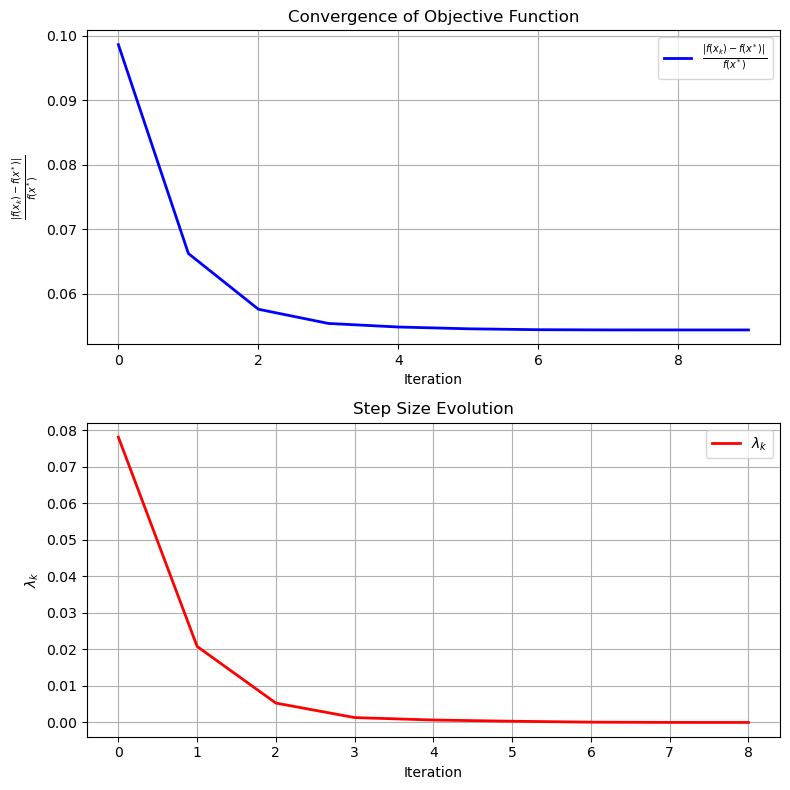

In [3]:
class LogisticRegression:

    def objective(self, x, A, b, gamma):
        logits = -b * (A.T @ x)
        loss = np.log1p(1 + np.exp(logits)).mean()
        reg = (gamma / 2) * np.linalg.norm(x)**2
        return loss + reg

    def gradient(self, x, A, b, gamma):
        N = len(b)
        logits = -b * (A.T @ x)
        probabilities = 1 / (1 + np.exp(logits))
        grad = -(A @ (b * probabilities)) / N + gamma * x
        return grad

    def step(self, f, grad_f, x_k, hist, direction, A, b, gamma, max_iter=20):
        lambda_k = 5 
        if len(hist) >= 2:
            lambda_k = (2 * (f(hist[-2], A, b, gamma) - f(x_k, A, b, gamma))) / (np.linalg.norm(grad_f(x_k, A, b, gamma))**2)
        grad_phi_0 = np.dot(grad_f(x_k, A, b, gamma), direction)

        for _ in range(max_iter):
            x_new = x_k + lambda_k * direction
            phi_lambda = f(x_new, A, b, gamma)

            x_temp =  x_new + lambda_k * direction
            phi_2lambda = f(x_temp, A, b, gamma)


            if phi_2lambda <= phi_lambda + (lambda_k / 2) * grad_phi_0:
                return lambda_k

            lambda_k *=  0.5  ## backtracking used as stated in the paper

        return lambda_k

    def run(self):
        # np.random.seed(0)

        N = 200
        d = 200
        A = np.random.randn(d, N)
        for j in range(1, N):
            A[:, j] = 0.5 * A[:, j - 1] + np.random.randn(d)

        x_star = np.random.randn(d)
        b = A.T @ x_star + 0.05 * np.random.randn(N)
        b = np.sign(b)

        gamma = 1 / N

        x_k = np.zeros(d)
        max_iters = 10
        tol = 1e-6

        x_history = [x_k.copy()]
        f_history = [self.objective(x_k, A, b, gamma)]
        lambda_history = []

        for i in range(max_iters):
            grad = self.gradient(x_k, A, b, gamma)
            direction = -grad

            lambda_k = self.step(self.objective, self.gradient, x_k, x_history, direction, A, b, gamma)

            x_new = x_k + lambda_k * direction

            x_history.append(x_new.copy())
            f_history.append(self.objective(x_new, A, b, gamma))
            lambda_history.append(lambda_k)

            if np.linalg.norm(x_new - x_k) < tol:
                print(f"Converged at iteration {i}")
                break

            x_k = x_new

        print("Final adaptive step size:", lambda_k)

        f_star = self.objective(x_star, A, b, gamma)

        f_diff_normalized = [f_k - f_star / f_star for f_k in f_history]

        self.plot_convergence(f_diff_normalized, lambda_history)

    def plot_convergence(self, f_diff_normalized, lambda_history):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

        ax1.plot(np.abs(f_diff_normalized), "b-", label=r"$\frac{|f(x_k) - f(x^*)|}{f(x^*)}$", linewidth=2)
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel(r"$\frac{|f(x_k) - f(x^*)|}{f(x^*)}$")
        ax1.set_title("Convergence of Objective Function")
        ax1.legend()
        ax1.grid()

        ax2.plot(lambda_history, "r-", label=r"$\lambda_k$", linewidth=2)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel(r"$\lambda_k$")
        ax2.set_title("Step Size Evolution")
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.show()


lr = LogisticRegression()
lr.run()

### Quadratic programming

Final adaptive step size: 0.003429299599025189


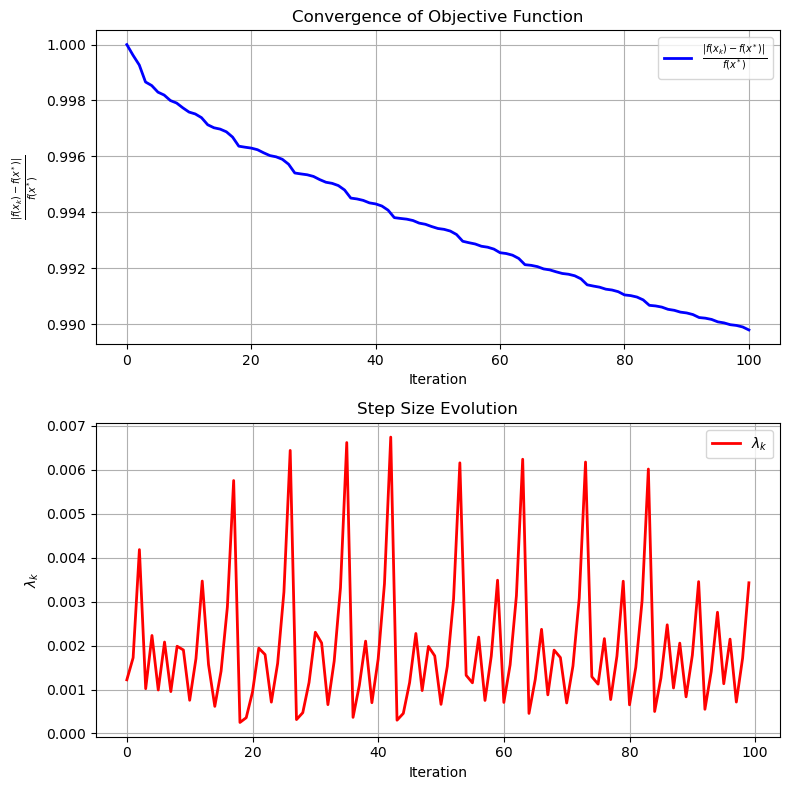

In [4]:
class QuadraticProgramming(LogisticRegression):
    
    def objective(self, x, B, b):
        return 0.5 * np.dot(x, B @ x) + np.dot(b, x)

    def gradient(self, x, B, b):
        return B @ x + b
    
    def step(self, f, grad_f, x_k, hist, direction, B, b, max_iter=20):
        lambda_k = 5
        if len(hist) >= 2:
            lambda_k = (2 * (f(hist[-2], B, b ) - f(x_k, B, b))) / (np.linalg.norm(grad_f(x_k, B, b))**2)
        grad_phi_0 = np.dot(grad_f(x_k, B, b), direction)

        for _ in range(max_iter):
            x_new = x_k + lambda_k * direction
            phi_lambda = f(x_new, B, b)

            x_temp =  x_new + lambda_k * direction
            phi_2lambda = f(x_temp, B, b)


            if phi_2lambda <= phi_lambda + (lambda_k / 2) * grad_phi_0:
                return lambda_k

            lambda_k *=  0.5  

        return lambda_k

    def run(self):
        d = 200
        A = np.random.randn(d, d)
        for j in range(1, d):
            A[:, j] = 0.5 * A[:, j - 1] + np.random.randn(d)

        B = A.T @ A  # Positive definite
        b = np.random.randn(d)
        b /= np.linalg.norm(b)  # Normalize b

        x_k = np.zeros(d)
        max_iters = 100
        tol = 1e-6

        x_history = [x_k.copy()]
        f_history = [self.objective(x_k, B, b)]
        lambda_history = []

        for i in range(max_iters):
            grad = self.gradient(x_k, B, b)
            direction = -grad

            lambda_k = self.step(self.objective, self.gradient, x_k, x_history, direction, B, b)

            x_new = x_k + lambda_k * direction

            x_history.append(x_new.copy())
            f_history.append(self.objective(x_new, B, b))
            lambda_history.append(lambda_k)

            if np.linalg.norm(x_new - x_k) < tol:
                print(f"Converged at iteration {i}")
                break

            x_k = x_new

        print("Final adaptive step size:", lambda_k)

        f_star = self.objective(np.linalg.solve(B, -b), B, b)  # Optimal solution f(x*) = f(B^(-1) * -b)
        f_diff_normalized = [(f_k - f_star) / abs(f_star) for f_k in f_history]

        self.plot_convergence(f_diff_normalized, lambda_history)


qp = QuadraticProgramming()
qp.run()


### Log Sum Exp

Final adaptive step size: 0.0993082890923681


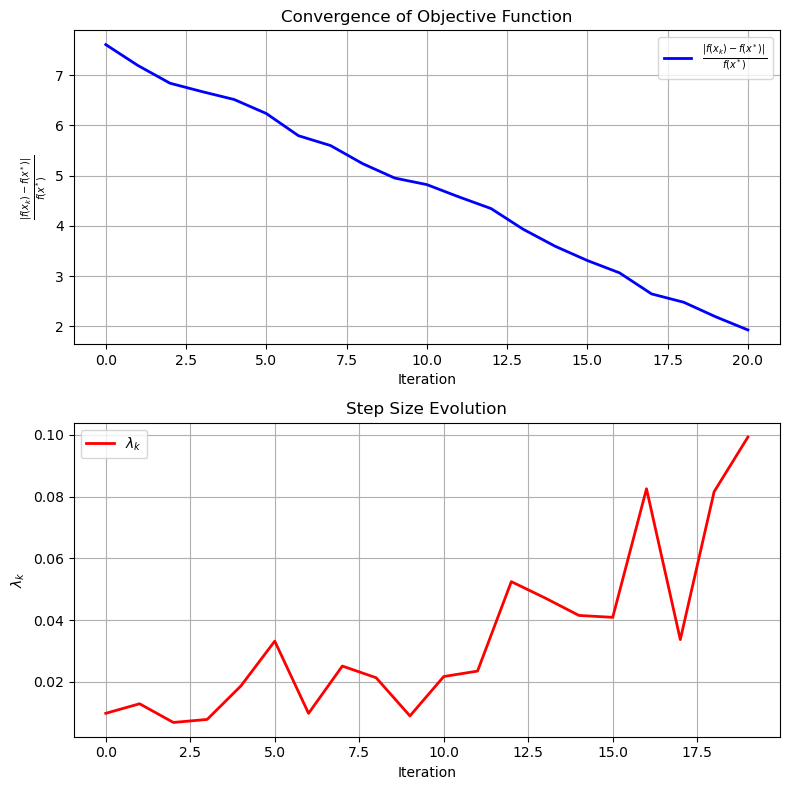

In [5]:
class LogSumExpOptimization(LogisticRegression):

    def objective(self, x, A, b, gamma):
        logits = A.T @ x - b
        loss = np.log(np.sum(np.exp(logits)))
        reg = (gamma / 2) * np.linalg.norm(x)**2
        return loss + reg

    def gradient(self, x, A, b, gamma):
        logits = A.T @ x - b
        exp_logits = np.exp(logits)
        probabilities = exp_logits / np.sum(exp_logits)
        grad = A @ probabilities + gamma * x
        return grad

    def run(self):
        N = 200
        d = 200
        A = np.random.randn(d, N)
        for j in range(1, N):
            A[:, j] = 0.5 * A[:, j - 1] + np.random.randn(d)

        x_star = np.random.randn(d)
        b = A.T @ x_star + 0.05 * np.random.randn(N)

        gamma = 1 / N
        x_k = np.zeros(d)
        max_iters = 20
        tol = 1e-6

        x_history = [x_k.copy()]
        f_history = [self.objective(x_k, A, b, gamma)]
        lambda_history = []

        for i in range(max_iters):
            grad = self.gradient(x_k, A, b, gamma)
            direction = -grad

            lambda_k = self.step(self.objective, self.gradient, x_k, x_history, direction, A, b, gamma)

            x_new = x_k + lambda_k * direction

            x_history.append(x_new.copy())
            f_history.append(self.objective(x_new, A, b, gamma))
            lambda_history.append(lambda_k)

            if np.linalg.norm(x_new - x_k) < tol:
                print(f"Converged at iteration {i}")
                break

            x_k = x_new

        print("Final adaptive step size:", lambda_k)

        f_star = self.objective(x_star, A, b, gamma)
        f_diff_normalized = [(f_k - f_star) / f_star for f_k in f_history]

        self.plot_convergence(f_diff_normalized, lambda_history)


lse = LogSumExpOptimization()
lse.run()

### Approximate Semidefinite Programming for the Max-Cut problem

Final adaptive step size: 1.2410726337458307


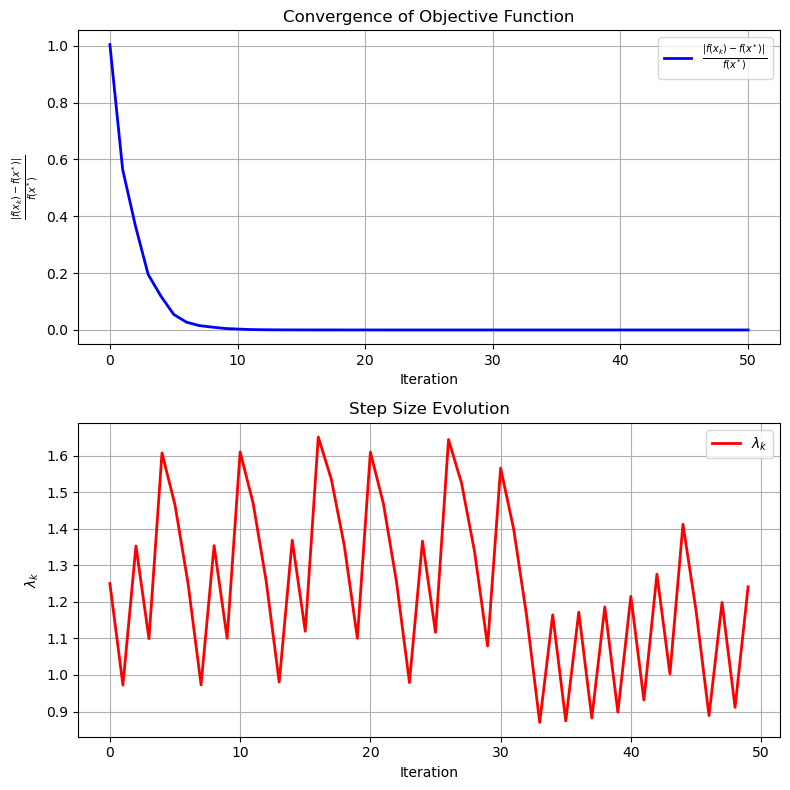

In [6]:
class ApproximateSDP(LogisticRegression):
    def objective(self, y, C, epsilon, eta):
        X = C + np.diag(y)
        eigvals = np.linalg.eigvalsh(X)

        max_eig = np.max(eigvals)
        log_sum_exp = epsilon * (np.log(np.sum(np.exp((eigvals - max_eig) / epsilon))) + max_eig / epsilon)
        
        reg = eta * np.linalg.norm(y)**2
        return log_sum_exp - np.sum(y) + reg

    def gradient(self, y, C, epsilon, eta):
        X = C + np.diag(y)

        eigvals, Q = np.linalg.eigh(X)
        max_eig = np.max(eigvals)
        exp_lambda = np.exp((eigvals - max_eig) / epsilon)
        weighted_Q = (Q * exp_lambda) @ Q.T
        grad_f = np.diag(weighted_Q / np.sum(exp_lambda)) - np.ones_like(y) + 2 * eta * y
        
        return grad_f

    def step(self, f, grad_f, x_k, hist, direction, C, epsilon, eta, max_iter=20):
        lambda_k = 5
        if len(hist) >= 2:
            lambda_k = (2 * (f(hist[-2], C, epsilon, eta) - f(x_k, C, epsilon, eta))) / (np.linalg.norm(grad_f(x_k, C, epsilon, eta))**2)
        grad_phi_0 = np.dot(grad_f(x_k, C, epsilon, eta), direction)

        for _ in range(max_iter):
            x_new = x_k + lambda_k * direction
            phi_lambda = f(x_new, C, epsilon, eta)

            x_temp =  x_new + lambda_k * direction
            phi_2lambda = f(x_temp, C, epsilon, eta)


            if phi_2lambda <= phi_lambda + (lambda_k / 2) * grad_phi_0:
                return lambda_k

            lambda_k *=  0.5

        return lambda_k


    def run(self):
        n = 100
        epsilon = 1e-5
        eta = 0.1

        G = np.random.randn(n, n)
        C = (G.T @ G) / np.linalg.norm(G, ord=2)**2 
        C += 1e-4 * np.eye(n) 

        y_k = np.zeros(n)
        max_iters = 50
        tol = 1e-6

        y_history = [y_k.copy()]
        f_history = [self.objective(y_k, C, epsilon, eta)]
        lambda_history = []

        for i in range(max_iters):
            grad = self.gradient(y_k, C, epsilon, eta)
            direction = -grad

            lambda_k = self.step(self.objective, self.gradient, y_k, y_history, direction, C, epsilon, eta)

            y_new = y_k + lambda_k * direction

            y_history.append(y_new.copy())
            f_history.append(self.objective(y_new, C, epsilon, eta))
            lambda_history.append(lambda_k)

            if np.linalg.norm(y_new - y_k) < tol:
                print(f"Converged at iteration {i}")
                break

            y_k = y_new

        print("Final adaptive step size:", lambda_k)

        f_star = min(f_history) ## here we could have probably used cvxpy 
        f_diff_normalized = [(f_k - f_star) / abs(f_star) for f_k in f_history]

        self.plot_convergence(f_diff_normalized, lambda_history)


sdp = ApproximateSDP()
sdp.run()


### ℓ1-Regularized least square

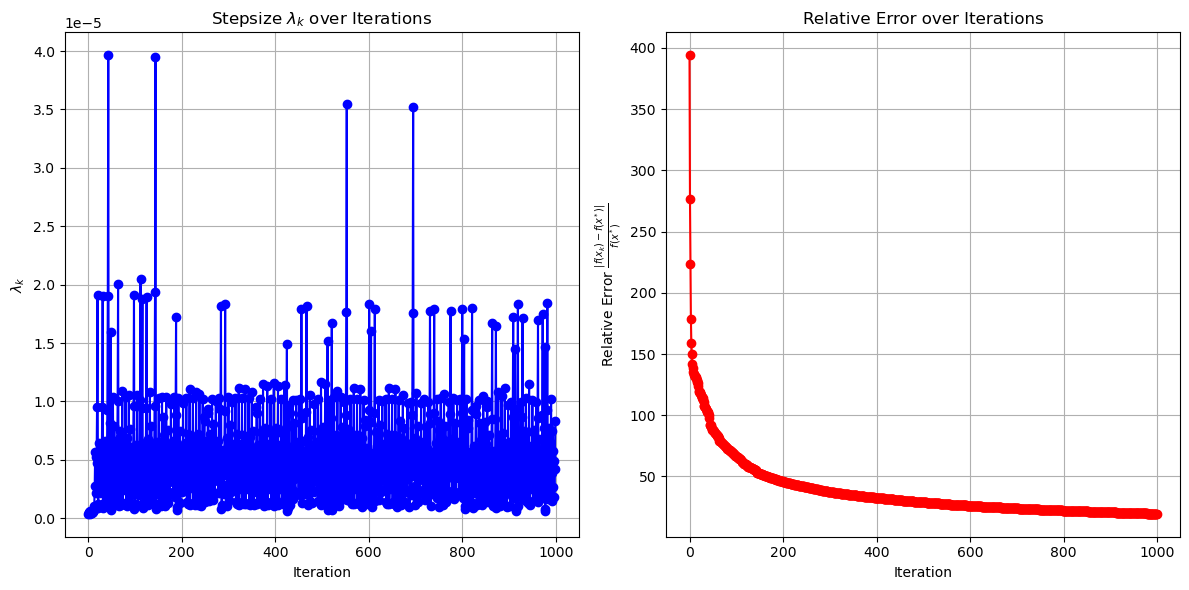

In [7]:
import cvxpy as cp

class L1RegularizedLeastSquares:
    def __init__(self, A, b, gamma):
        """
        Initialize the L1-regularized least squares problem.

        Parameters:
        - A: The design matrix (n x d).
        - b: The target vector (n x 1).
        - gamma: The regularization parameter.
        """
        self.A = A
        self.b = b
        self.gamma = gamma

    def objective_function(self, x):
        """
        Compute the objective function f(x) = ||Ax - b||^2.
        """
        return np.linalg.norm(self.A @ x - self.b)**2

    def regularization_term(self, x):
        """
        Compute the L1 regularization term h(x) = gamma * ||x||_1.
        """
        return self.gamma * np.linalg.norm(x, ord=1)

    def gradient_of_f(self, x):
        """
        Compute the gradient of the objective function f(x).
        """
        return 2 * self.A.T @ (self.A @ x - self.b)

    def proximal_operator(self, x, lambda_k):
        """
        Compute the proximal operator for the L1 regularization term.
        """
        return np.sign(x) * np.maximum(np.abs(x) - lambda_k * self.gamma, 0)

    def gradient_mapping(self, x, lambda_k):
        """
        Compute the gradient mapping G^f_{λh}(x).
        """
        grad = self.gradient_of_f(x)
        prox_point = self.proximal_operator(x - lambda_k * grad, lambda_k)
        return (1 / lambda_k) * (x - prox_point)

    def compute_stepsize(self, x_k, x_prev, max_iter=20):
        """
        Compute the stepsize lambda_k using the adaptive stepsize rule.
        """
        # Initialize lambda_k using the provided formula
        if x_prev is not None:
            lambda_k = (2 * (self.objective_function(x_prev) - self.objective_function(x_k))) / (np.linalg.norm(self.gradient_of_f(x_k))**2)
        else:
            lambda_k = 1 / (2 * np.linalg.norm(self.A)**2)  # Fallback initialization

        for _ in range(max_iter):
            direction = -self.gradient_mapping(x_k, lambda_k)
            x_new = x_k + lambda_k * direction
            phi_lambda = self.objective_function(x_new)

            x_temp = x_new + lambda_k * direction
            phi_2lambda = self.objective_function(x_temp)

            grad_mapping = self.gradient_mapping(x_k, lambda_k)
            grad_f_xk = self.gradient_of_f(x_k)

            # Check the condition from the paper
            if phi_2lambda <= phi_lambda - lambda_k * (grad_mapping.T @ grad_f_xk) + (lambda_k / 2) * np.linalg.norm(grad_mapping)**2:
                return lambda_k

            lambda_k *= 0.5  # Backtracking (reduce stepsize)

        return lambda_k

    def solve(self, x0, max_iter=1000, tol=1e-6):
        """
        Solve the L1-regularized least squares problem using proximal gradient descent.

        Parameters:
        - x0: Initial guess for the solution.
        - max_iter: Maximum number of iterations.
        - tol: Convergence tolerance.

        Returns:
        - x: The computed solution.
        """
        x = x0
        x_prev = None  # Initialize x_prev as None for the first iteration

        # Lists to store lambda_k and relative error for plotting
        self.lambda_history = []
        self.relative_error_history = []

        # Compute the optimal solution using CVXPY
        x_star = self.compute_optimal_solution()
        f_star = self.objective_function(x_star)

        for k in range(max_iter):
            lambda_k = self.compute_stepsize(x, x_prev)  # Compute stepsize
            direction = -self.gradient_mapping(x, lambda_k)  # Compute direction
            x_new = self.proximal_operator(x + lambda_k * direction, lambda_k)  # Update x using proximal operator

            # Store lambda_k and relative error
            self.lambda_history.append(lambda_k)
            relative_error = np.abs(self.objective_function(x_new) - f_star) / f_star
            self.relative_error_history.append(relative_error)

            # Check for convergence
            if np.linalg.norm(x_new - x) < tol:
                break

            x_prev = x  # Update x_prev for the next iteration
            x = x_new  # Update x for the next iteration

        return x

    def compute_optimal_solution(self):
        """
        Compute the optimal solution using CVXPY.
        """
        x = cp.Variable((self.A.shape[1], 1))
        objective = cp.Minimize(cp.sum_squares(self.A @ x - self.b) + self.gamma * cp.norm(x, 1))
        problem = cp.Problem(objective)
        problem.solve()
        return x.value

    def plot_results(self):
        """
        Plot the stepsize lambda_k and relative error over iterations.
        """
        plt.figure(figsize=(12, 6))

        # Plot stepsize lambda_k over iterations
        plt.subplot(1, 2, 1)
        plt.plot(self.lambda_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('$\lambda_k$')
        plt.title('Stepsize $\lambda_k$ over Iterations')
        plt.grid()

        # Plot relative error over iterations
        plt.subplot(1, 2, 2)
        plt.plot(self.relative_error_history, marker='o', linestyle='-', color='r')
        plt.xlabel('Iteration')
        plt.ylabel('Relative Error $\\frac{|f(x_k) - f(x^*)|}{f(x^*)}$')
        plt.title('Relative Error over Iterations')
        plt.grid()

        plt.tight_layout()
        plt.show()

# Example usage
np.random.seed(42)  # Set a seed for reproducibility
N = 200
A = 5 * np.random.rand(200, 200)
b = np.random.rand(200, 1)
gamma = 1 / N

# Create problem instance
problem = L1RegularizedLeastSquares(A, b, gamma)

# Initial guess (all zeros)
x0 = np.zeros((N, 1))

# Solve the problem
solution = problem.solve(x0)

# Plot the results
problem.plot_results()

# Print the solution
# print("Solution x:")
# print(solution)

### ℓ1-Constrained least square

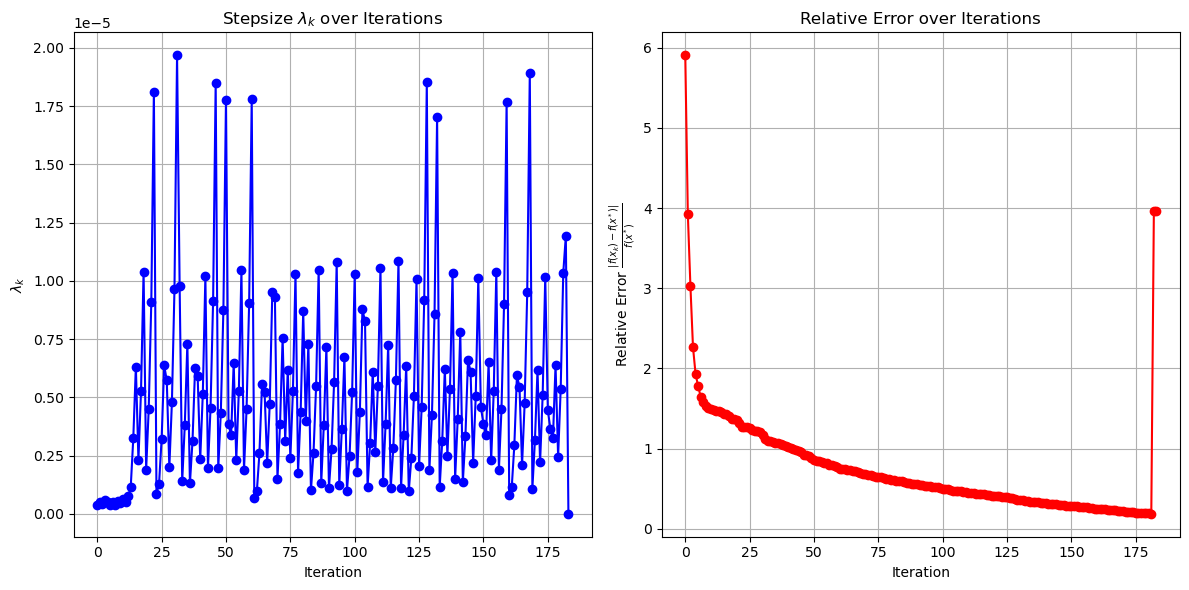

In [8]:
class L1ConstrainedLeastSquares:
    def __init__(self, A, b):
        """
        Initialize the L1-constrained least squares problem.

        Parameters:
        - A: The design matrix (n x d).
        - b: The target vector (n x 1).
        """
        self.A = A
        self.b = b

    def objective_function(self, x):
        """
        Compute the objective function f(x) = ||Ax - b||^2.
        """
        return np.linalg.norm(self.A @ x - self.b)**2

    def gradient_of_f(self, x):
        """
        Compute the gradient of the objective function f(x).
        """
        return 2 * self.A.T @ (self.A @ x - self.b)

    def project_onto_l1_ball(self, x):
        """
        Project x onto the L1-ball B_1[0, 1] (i.e., ||x||_1 <= 1).
        """
        if np.linalg.norm(x, ord=1) <= 1:
            return x
        else:
            # Use the projection algorithm for the L1-ball
            u = np.abs(x)
            idx = np.argsort(u)[::-1]  # Sort in descending order
            u_sorted = u[idx]
            cumsum = np.cumsum(u_sorted)
            rho = np.where(u_sorted * np.arange(1, len(u) + 1) > (cumsum - 1))[0][-1]
            theta = (cumsum[rho] - 1) / (rho + 1)
            w = np.maximum(u - theta, 0)
            return np.sign(x) * w

    def gradient_mapping(self, x, lambda_k):
        """
        Compute the gradient mapping G^f_{λh}(x).
        """
        grad = self.gradient_of_f(x)
        prox_point = self.project_onto_l1_ball(x - lambda_k * grad)
        return (1 / lambda_k) * (x - prox_point)

    def compute_stepsize(self, x_k, x_prev, max_iter=20):
        """
        Compute the stepsize lambda_k using the adaptive stepsize rule.
        """
        # Initialize lambda_k using the provided formula
        if x_prev is not None:
            lambda_k = (2 * (self.objective_function(x_prev) - self.objective_function(x_k))) / (np.linalg.norm(self.gradient_of_f(x_k))**2)
        else:
            lambda_k = 1 / (2 * np.linalg.norm(self.A)**2)  # Fallback initialization

        for _ in range(max_iter):
            direction = -self.gradient_mapping(x_k, lambda_k)
            x_new = x_k + lambda_k * direction
            phi_lambda = self.objective_function(x_new)

            x_temp = x_new + lambda_k * direction
            phi_2lambda = self.objective_function(x_temp)

            grad_mapping = self.gradient_mapping(x_k, lambda_k)
            grad_f_xk = self.gradient_of_f(x_k)

            # Check the condition from the paper
            if phi_2lambda <= phi_lambda - lambda_k * (grad_mapping.T @ grad_f_xk) + (lambda_k / 2) * np.linalg.norm(grad_mapping)**2:
                return lambda_k

            lambda_k *= 0.5  # Backtracking (reduce stepsize)

        return lambda_k

    def solve(self, x0, max_iter=1000, tol=1e-6):
        """
        Solve the L1-constrained least squares problem using projected gradient descent.

        Parameters:
        - x0: Initial guess for the solution.
        - max_iter: Maximum number of iterations.
        - tol: Convergence tolerance.

        Returns:
        - x: The computed solution.
        """
        x = x0
        x_prev = None  # Initialize x_prev as None for the first iteration

        # Lists to store lambda_k and relative error for plotting
        self.lambda_history = []
        self.relative_error_history = []

        # Compute the optimal solution using CVXPY
        x_star = self.compute_optimal_solution()
        f_star = self.objective_function(x_star)

        for k in range(max_iter):
            lambda_k = self.compute_stepsize(x, x_prev)  # Compute stepsize
            direction = -self.gradient_mapping(x, lambda_k)  # Compute direction
            x_new = self.project_onto_l1_ball(x + lambda_k * direction)  # Update x using projection

            # Store lambda_k and relative error
            self.lambda_history.append(lambda_k)
            relative_error = np.abs(self.objective_function(x_new) - f_star) / f_star
            self.relative_error_history.append(relative_error)

            # Check for convergence
            if np.linalg.norm(x_new - x) < tol:
                break

            x_prev = x  # Update x_prev for the next iteration
            x = x_new  # Update x for the next iteration

        return x

    def compute_optimal_solution(self):
        """
        Compute the optimal solution using CVXPY.
        """
        x = cp.Variable((self.A.shape[1], 1))
        objective = cp.Minimize(cp.sum_squares(self.A @ x - self.b))
        constraint = [cp.norm(x, 1) <= 1]
        problem = cp.Problem(objective, constraint)
        problem.solve()
        return x.value

    def plot_results(self):
        """
        Plot the stepsize lambda_k and relative error over iterations.
        """
        plt.figure(figsize=(12, 6))

        # Plot stepsize lambda_k over iterations
        plt.subplot(1, 2, 1)
        plt.plot(self.lambda_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('$\lambda_k$')
        plt.title('Stepsize $\lambda_k$ over Iterations')
        plt.grid()

        # Plot relative error over iterations
        plt.subplot(1, 2, 2)
        plt.plot(self.relative_error_history, marker='o', linestyle='-', color='r')
        plt.xlabel('Iteration')
        plt.ylabel('Relative Error $\\frac{|f(x_k) - f(x^*)|}{f(x^*)}$')
        plt.title('Relative Error over Iterations')
        plt.grid()

        plt.tight_layout()
        plt.show()

# Example usage
np.random.seed(41)  # Set a seed for reproducibility
N = 200
A = 5 * np.random.rand(200, 200)
b = np.random.rand(200, 1)

# Create problem instance
problem = L1ConstrainedLeastSquares(A, b)

# Initial guess (all zeros)
x0 = np.zeros((N, 1))

# Solve the problem
solution = problem.solve(x0)

# Plot the results
problem.plot_results()

# Print the solution
# print("Solution x:")
# print(solution)

### ℓ1-Regularized logistic regression

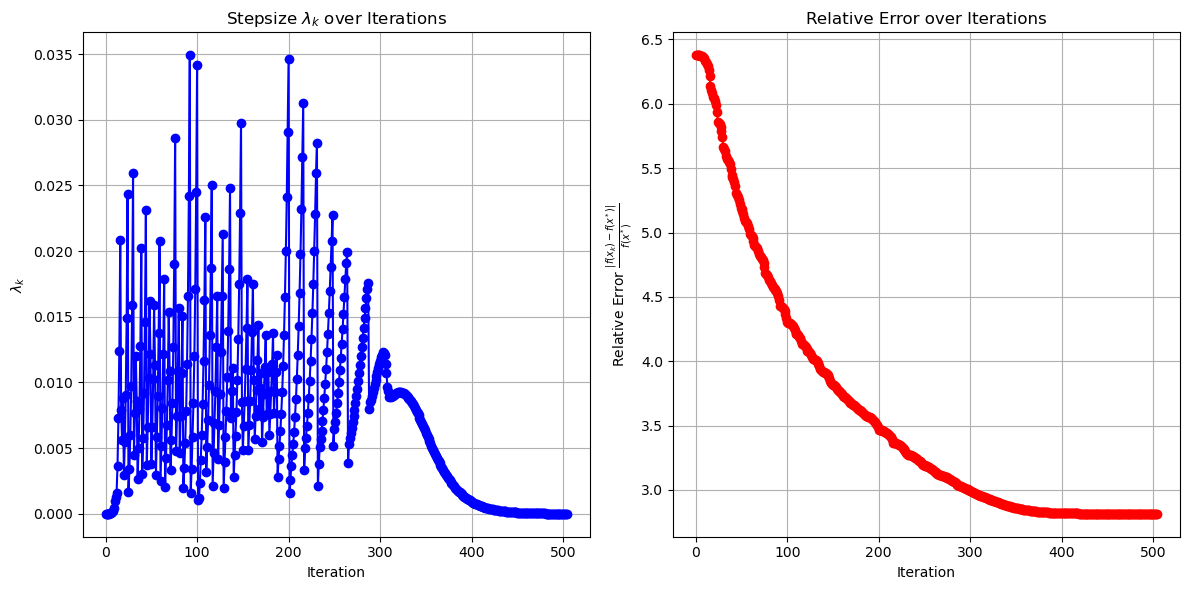

In [9]:
class L1RegularizedLogisticRegression:
    def __init__(self, A, b, gamma):
        """
        Initialize the L1-regularized logistic regression problem.

        Parameters:
        - A: The design matrix (n x d).
        - b: The target vector (n x 1), with values in {-1, 1}.
        - gamma: The regularization parameter.
        """
        self.A = A
        self.b = b
        self.gamma = gamma
        self.N = A.shape[0]  # Number of samples

    def logistic_loss(self, x):
        """
        Compute the logistic loss function.
        """
        z = self.A @ x
        return np.mean(np.log(1 + np.exp(-self.b * z)))

    def regularization_term(self, x):
        """
        Compute the L1 regularization term h(x) = gamma * ||x||_1.
        """
        return self.gamma * np.linalg.norm(x, ord=1)

    def gradient_of_logistic_loss(self, x):
        """
        Compute the gradient of the logistic loss function.
        """
        z = self.A @ x
        p = 1 / (1 + np.exp(-self.b * z))  # Probability of class 1
        grad = -(self.A.T @ (self.b * (1 - p))) / self.N
        return grad

    def proximal_operator(self, x, lambda_k):
        """
        Compute the proximal operator for the L1 regularization term.
        """
        return np.sign(x) * np.maximum(np.abs(x) - lambda_k * self.gamma, 0)

    def gradient_mapping(self, x, lambda_k):
        """
        Compute the gradient mapping G^f_{λh}(x).
        """
        grad = self.gradient_of_logistic_loss(x)
        prox_point = self.proximal_operator(x - lambda_k * grad, lambda_k)
        return (1 / lambda_k) * (x - prox_point)

    def compute_stepsize(self, x_k, x_prev, max_iter=20):
        """
        Compute the stepsize lambda_k using the adaptive stepsize rule.
        """
        # Initialize lambda_k using the provided formula
        if x_prev is not None:
            lambda_k = (2 * (self.logistic_loss(x_prev) - self.logistic_loss(x_k))) / (np.linalg.norm(self.gradient_of_logistic_loss(x_k))**2)
        else:
            lambda_k = 1 / (2 * np.linalg.norm(self.A)**2)  # Fallback initialization

        for _ in range(max_iter):
            direction = -self.gradient_mapping(x_k, lambda_k)
            x_new = x_k + lambda_k * direction
            phi_lambda = self.logistic_loss(x_new)

            x_temp = x_new + lambda_k * direction
            phi_2lambda = self.logistic_loss(x_temp)

            grad_mapping = self.gradient_mapping(x_k, lambda_k)
            grad_f_xk = self.gradient_of_logistic_loss(x_k)

            # Check the condition from the paper
            if phi_2lambda <= phi_lambda - lambda_k * (grad_mapping.T @ grad_f_xk) + (lambda_k / 2) * np.linalg.norm(grad_mapping)**2:
                return lambda_k

            lambda_k *= 0.5  # Backtracking (reduce stepsize)

        return lambda_k

    def solve(self, x0, max_iter=1000, tol=1e-6):
        """
        Solve the L1-regularized logistic regression problem using proximal gradient descent.

        Parameters:
        - x0: Initial guess for the solution.
        - max_iter: Maximum number of iterations.
        - tol: Convergence tolerance.

        Returns:
        - x: The computed solution.
        """
        x = x0
        x_prev = None  # Initialize x_prev as None for the first iteration

        # Lists to store lambda_k and relative error for plotting
        self.lambda_history = []
        self.relative_error_history = []

        # Compute the optimal solution using CVXPY
        x_star = self.compute_optimal_solution()
        f_star = self.logistic_loss(x_star)

        for k in range(max_iter):
            lambda_k = self.compute_stepsize(x, x_prev)  # Compute stepsize
            direction = -self.gradient_mapping(x, lambda_k)  # Compute direction
            x_new = self.proximal_operator(x + lambda_k * direction, lambda_k)  # Update x using proximal operator

            # Store lambda_k and relative error
            self.lambda_history.append(lambda_k)
            relative_error = np.abs(self.logistic_loss(x_new) - f_star) / f_star
            self.relative_error_history.append(relative_error)

            # Check for convergence
            if np.linalg.norm(x_new - x) < tol:
                break

            x_prev = x  # Update x_prev for the next iteration
            x = x_new  # Update x for the next iteration

        return x

    def compute_optimal_solution(self):
        """
        Compute the optimal solution using CVXPY.
        """
        x = cp.Variable((self.A.shape[1], 1))
        z = self.A @ x
        logistic_loss = cp.sum(cp.logistic(-cp.multiply(self.b, z))) / self.N
        objective = cp.Minimize(logistic_loss + self.gamma * cp.norm(x, 1))
        problem = cp.Problem(objective)
        problem.solve()
        return x.value

    def plot_results(self):
        """
        Plot the stepsize lambda_k and relative error over iterations.
        """
        plt.figure(figsize=(12, 6))

        # Plot stepsize lambda_k over iterations
        plt.subplot(1, 2, 1)
        plt.plot(self.lambda_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('$\lambda_k$')
        plt.title('Stepsize $\lambda_k$ over Iterations')
        plt.grid()

        # Plot relative error over iterations
        plt.subplot(1, 2, 2)
        plt.plot(self.relative_error_history, marker='o', linestyle='-', color='r')
        plt.xlabel('Iteration')
        plt.ylabel('Relative Error $\\frac{|f(x_k) - f(x^*)|}{f(x^*)}$')
        plt.title('Relative Error over Iterations')
        plt.grid()

        plt.tight_layout()
        plt.show()

# Example usage
np.random.seed(42)  # Set a seed for reproducibility
N = 200
A = 5 * np.random.rand(200, 200)
b = np.random.choice([-1, 1], size=(200, 1))  # Binary labels in {-1, 1}
gamma = 1 / N

# Create problem instance
problem = L1RegularizedLogisticRegression(A, b, gamma)

# Initial guess (all zeros)
x0 = np.zeros((N, 1))

# Solve the problem
solution = problem.solve(x0)

# Plot the results
problem.plot_results()

# Print the solution
# print("Solution x:")
# print(solution)

### ℓ1-Regularized least square (acc)

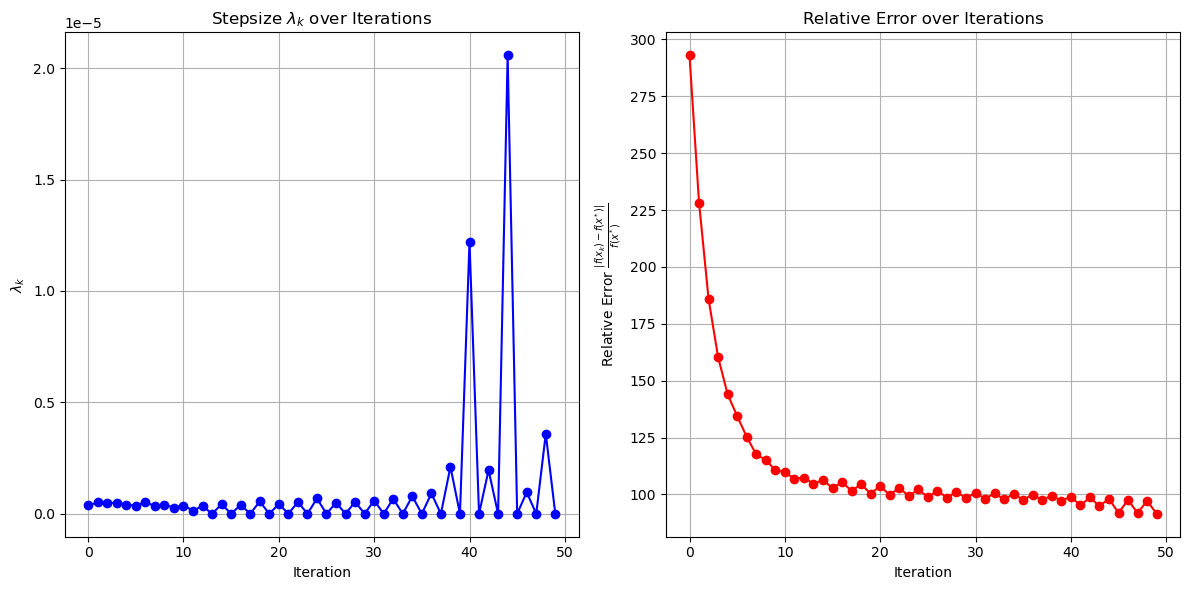

In [153]:
class L1RegularizedLeastSquares:
    def __init__(self, A, b, gamma):
        
        self.A = A
        self.b = b
        self.gamma = gamma

    def objective_function(self, x):
       
        return np.linalg.norm(self.A @ x - self.b)**2

    def regularization_term(self, x):
        
        return self.gamma * np.linalg.norm(x, ord=1)

    def gradient_of_f(self, x):
        
        return 2 * self.A.T @ (self.A @ x - self.b)

    def proximal_operator(self, x, lambda_k):
        
        return np.sign(x) * np.maximum(np.abs(x) - lambda_k * self.gamma, 0)

    def gradient_mapping(self, x, lambda_k):
        
        grad = self.gradient_of_f(x)
        prox_point = self.proximal_operator(x - lambda_k * grad, lambda_k)
        return (1 / lambda_k) * (x - prox_point)

    def compute_stepsize(self, x_k, x_prev, lambda_k_last, max_iter=20):

        if x_prev is not None:
    
            lambda_k =  (2 * (self.objective_function(x_prev) - self.objective_function(x_k))) / (np.linalg.norm(self.gradient_of_f(x_k))**2)
        else:
            lambda_k = 1 / (2 * np.linalg.norm(self.A)**2) 

        # print("11", lambda_k)

        for iter in range(max_iter):
            direction = -self.gradient_mapping(x_k, lambda_k )
            x_new = x_k + lambda_k * direction
            phi_lambda = self.objective_function(x_new)

            x_temp = x_new + lambda_k * direction
            phi_2lambda = self.objective_function(x_temp)

            grad_mapping = self.gradient_mapping(x_k, lambda_k)
            grad_f_xk = self.gradient_of_f(x_k)

            if (phi_2lambda <= phi_lambda - lambda_k * (grad_mapping.T @ grad_f_xk) + (lambda_k / 2) * np.linalg.norm(grad_mapping)**2):
                return lambda_k

            lambda_k *= 0.5 

        # print("dd", lambda_k, "  ", iter)

        return lambda_k

    def solve(self, x0, max_iter=50, tol=1e-6):
       
        x = x0
        x_prev = None  # Initialize x_prev as None for the first iteration

        # Lists to store lambda_k and relative error for plotting
        self.lambda_history = []
        self.relative_error_history = []

        # Compute the optimal solution using CVXPY
        x_star = self.compute_optimal_solution()
        f_star = self.objective_function(x_star)

        # TODO check if needed to change the initial values
        beta_k = 0.1
        lambda_k_last = 100 # self.compute_stepsize(x, x_prev, 100)
        grad_map_last = 0
        d_k_last = 0 

        for k in range(max_iter):
            beta_k = (1 + np.sqrt(1 + 4 * beta_k**2)) / 2
            beta_k_next = (1 + np.sqrt(1 + 4 * beta_k**2)) / 2
            gamma_k = (1 - beta_k) / beta_k_next

            lambda_k = self.compute_stepsize(x, x_prev, lambda_k_last)  # Compute stepsize
            # print(lambda_k)
            grad_map = self.gradient_mapping(x, lambda_k )
            # print(np.linalg.norm(grad_map))
            # print(gamma_k)
            d_k = gamma_k * (lambda_k_last/lambda_k * d_k_last - (1 + 1/gamma_k) * grad_map + (lambda_k_last / lambda_k) * grad_map_last)
            # print(np.linalg.norm(d_k))

            x_new = self.proximal_operator(x + lambda_k * d_k, lambda_k )  # Update x using proximal operator

            # Store lambda_k and relative error
            self.lambda_history.append(lambda_k)
            relative_error = np.abs(self.objective_function(x_new) - f_star) / f_star
            self.relative_error_history.append(relative_error)

            # Check for convergence
            if np.linalg.norm(x_new - x) < tol:
                break

            x_prev = x  # Update x_prev for the next iteration
            x = x_new  # Update x for the next iteration
            lambda_k_last = lambda_k
            grad_map_last = grad_map
            d_k_last = d_k

        return x

    def compute_optimal_solution(self):
        
        x = cp.Variable((self.A.shape[1], 1))
        objective = cp.Minimize(cp.sum_squares(self.A @ x - self.b) + self.gamma * cp.norm(x, 1))
        problem = cp.Problem(objective)
        problem.solve()
        return x.value

    def plot_results(self):
        """
        Plot the stepsize lambda_k and relative error over iterations.
        """
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.lambda_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('$\lambda_k$')
        plt.title('Stepsize $\lambda_k$ over Iterations')
        plt.grid()

        # Plot relative error over iterations
        plt.subplot(1, 2, 2)
        plt.plot(self.relative_error_history, marker='o', linestyle='-', color='r')
        plt.xlabel('Iteration')
        plt.ylabel('Relative Error $\\frac{|f(x_k) - f(x^*)|}{f(x^*)}$')
        plt.title('Relative Error over Iterations')
        plt.grid()

        plt.tight_layout()
        plt.show()

N = 200
A = 5 * np.random.rand(200, 200)
b = np.random.rand(200, 1)
gamma = 1 / N

problem = L1RegularizedLeastSquares(A, b, gamma)

x0 = np.zeros((N, 1))

solution = problem.solve(x0)

problem.plot_results()

### ℓ1-Regularized logistic regression (acc)

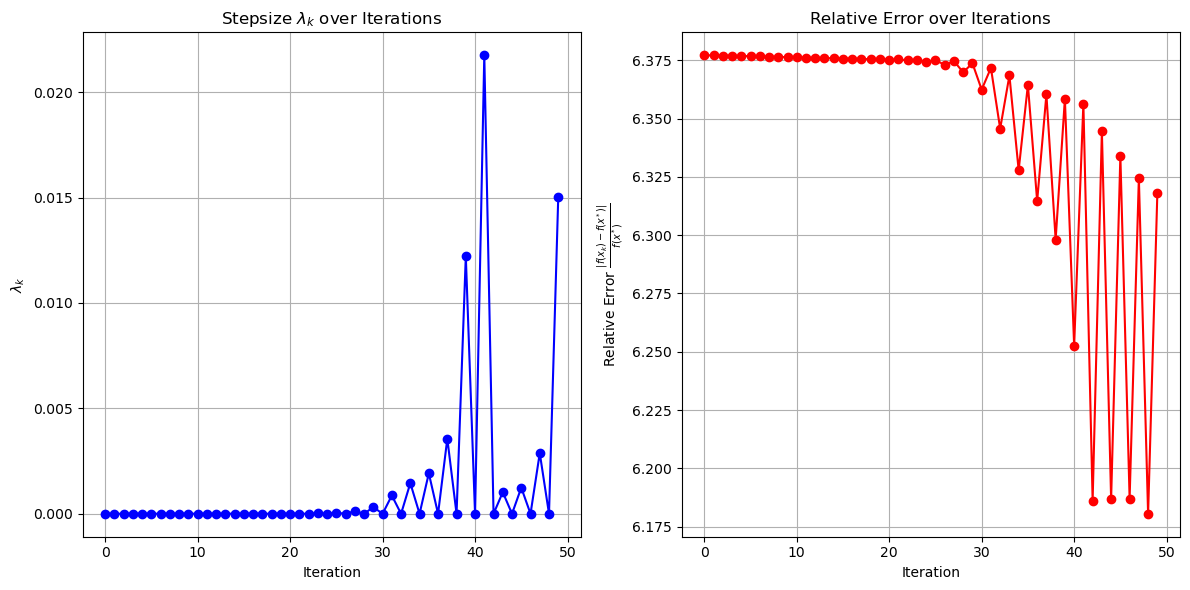

In [164]:
class L1RegularizedLogisticRegression:
    def __init__(self, A, b, gamma):
        """
        Initialize the L1-regularized logistic regression problem.

        Parameters:
        - A: The design matrix (n x d).
        - b: The target vector (n x 1), with values in {-1, 1}.
        - gamma: The regularization parameter.
        """
        self.A = A
        self.b = b
        self.gamma = gamma
        self.N = A.shape[0]  # Number of samples

    def logistic_loss(self, x):
        """
        Compute the logistic loss function.
        """
        z = self.A @ x
        return np.mean(np.log(1 + np.exp(-self.b * z)))

    def regularization_term(self, x):
        """
        Compute the L1 regularization term h(x) = gamma * ||x||_1.
        """
        return self.gamma * np.linalg.norm(x, ord=1)

    def gradient_of_logistic_loss(self, x):
        """
        Compute the gradient of the logistic loss function.
        """
        z = self.A @ x
        p = 1 / (1 + np.exp(-self.b * z))  # Probability of class 1
        grad = -(self.A.T @ (self.b * (1 - p))) / self.N
        return grad

    def proximal_operator(self, x, lambda_k):
        """
        Compute the proximal operator for the L1 regularization term.
        """
        return np.sign(x) * np.maximum(np.abs(x) - lambda_k * self.gamma, 0)

    def gradient_mapping(self, x, lambda_k):
        """
        Compute the gradient mapping G^f_{λh}(x).
        """
        grad = self.gradient_of_logistic_loss(x)
        prox_point = self.proximal_operator(x - lambda_k * grad, lambda_k)
        return (1 / lambda_k) * (x - prox_point)

    def compute_stepsize(self, x_k, x_prev, lambda_k_last, max_iter=20):
        """
        Compute the stepsize lambda_k using the adaptive stepsize rule.
        """
        # Initialize lambda_k using the provided formula
        if x_prev is not None:
            lambda_k = (2 * (self.logistic_loss(x_prev) - self.logistic_loss(x_k))) / (np.linalg.norm(self.gradient_of_logistic_loss(x_k))**2)
        else:
            lambda_k = 1 / (2 * np.linalg.norm(self.A)**2)  # Fallback initialization

        for _ in range(max_iter):
            direction = -self.gradient_mapping(x_k, lambda_k)
            x_new = x_k + lambda_k * direction
            phi_lambda = self.logistic_loss(x_new)

            x_temp = x_new + lambda_k * direction
            phi_2lambda = self.logistic_loss(x_temp)

            grad_mapping = self.gradient_mapping(x_k, lambda_k)
            grad_f_xk = self.gradient_of_logistic_loss(x_k)

            # Check the condition from the paper
            if (phi_2lambda <= phi_lambda - lambda_k * (grad_mapping.T @ grad_f_xk) + (lambda_k / 2) * np.linalg.norm(grad_mapping)**2) :
                return lambda_k

            lambda_k *= 0.5  # Backtracking (reduce stepsize)

        return lambda_k

    def solve(self, x0, max_iter=50, tol=1e-6):
        """
        Solve the L1-regularized logistic regression problem using proximal gradient descent.

        Parameters:
        - x0: Initial guess for the solution.
        - max_iter: Maximum number of iterations.
        - tol: Convergence tolerance.

        Returns:
        - x: The computed solution.
        """
        x = x0
        x_prev = None  # Initialize x_prev as None for the first iteration

        # Lists to store lambda_k and relative error for plotting
        self.lambda_history = []
        self.relative_error_history = []

        # Compute the optimal solution using CVXPY
        x_star = self.compute_optimal_solution()
        f_star = self.logistic_loss(x_star)

        # TODO check if needed to change the initial values
        beta_k = 0.1
        lambda_k_last = self.compute_stepsize(x, x_prev, 100)
        grad_map_last = 0
        d_k_last = 0 

        for k in range(max_iter):
            beta_k = (1 + np.sqrt(1 + 4 * beta_k**2)) / 2
            beta_k_next = (1 + np.sqrt(1 + 4 * beta_k**2)) / 2
            gamma_k = (1 - beta_k) / beta_k_next

            lambda_k = self.compute_stepsize(x, x_prev, lambda_k_last)  # Compute stepsize
            grad_map = self.gradient_mapping(x, lambda_k)
            d_k = gamma_k * (lambda_k_last/lambda_k * d_k_last - (1 + 1/gamma_k) * grad_map + (lambda_k_last / lambda_k) * grad_map_last)  
            x_new = self.proximal_operator(x + lambda_k * d_k, lambda_k)  # Update x using proximal operator

            # Store lambda_k and relative error
            self.lambda_history.append(lambda_k)
            relative_error = np.abs(self.logistic_loss(x_new) - f_star) / f_star
            self.relative_error_history.append(relative_error)

            # Check for convergence
            if np.linalg.norm(x_new - x) < tol:
                break

            x_prev = x  # Update x_prev for the next iteration
            x = x_new  # Update x for the next iteration
            lambda_k_last = lambda_k
            grad_map_last = grad_map
            d_k_last = d_k

        return x

    def compute_optimal_solution(self):
        """
        Compute the optimal solution using CVXPY.
        """
        x = cp.Variable((self.A.shape[1], 1))
        z = self.A @ x
        logistic_loss = cp.sum(cp.logistic(-cp.multiply(self.b, z))) / self.N
        objective = cp.Minimize(logistic_loss + self.gamma * cp.norm(x, 1))
        problem = cp.Problem(objective)
        problem.solve()
        return x.value

    def plot_results(self):
        """
        Plot the stepsize lambda_k and relative error over iterations.
        """
        plt.figure(figsize=(12, 6))

        # Plot stepsize lambda_k over iterations
        plt.subplot(1, 2, 1)
        plt.plot(self.lambda_history, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('$\lambda_k$')
        plt.title('Stepsize $\lambda_k$ over Iterations')
        plt.grid()

        # Plot relative error over iterations
        plt.subplot(1, 2, 2)
        plt.plot(self.relative_error_history, marker='o', linestyle='-', color='r')
        plt.xlabel('Iteration')
        plt.ylabel('Relative Error $\\frac{|f(x_k) - f(x^*)|}{f(x^*)}$')
        plt.title('Relative Error over Iterations')
        plt.grid()

        plt.tight_layout()
        plt.show()

# Example usage
np.random.seed(42)  # Set a seed for reproducibility
N = 200
A = 5 * np.random.rand(200, 200)
b = np.random.choice([-1, 1], size=(200, 1))  # Binary labels in {-1, 1}
gamma = 1 / N

# Create problem instance
problem = L1RegularizedLogisticRegression(A, b, gamma)

# Initial guess (all zeros)
x0 = np.zeros((N, 1))

# Solve the problem
solution = problem.solve(x0)

# Plot the results
problem.plot_results()

# Print the solution
# print("Solution x:")
# print(solution)